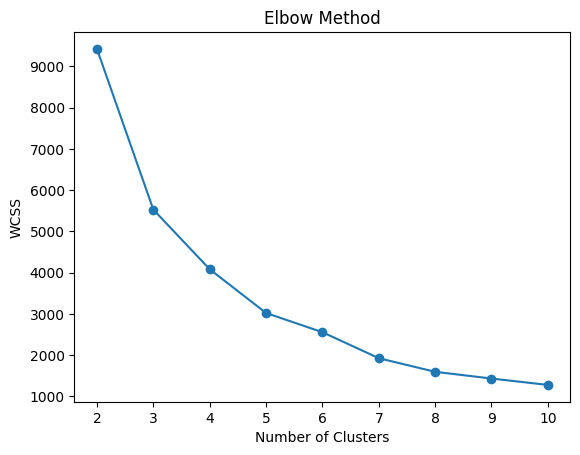


KMeans Silhouette Score: 0.6142804196098184
KMeans Calinski-Harabasz Index: 3222.798251343057
KMeans Davies-Bouldin Index: 0.7440383620906693

DBSCAN Grid Search Results:
    eps  min_samples  n_clusters  silhouette  calinski_harabasz  \
0   0.5            3           5    0.484657          46.911503   
1   0.5            5           3    0.656138          90.065893   
2   0.5            7           1         NaN                NaN   
3   1.0            3           2    0.826012         130.509618   
4   1.0            5           1         NaN                NaN   
5   1.0            7           1         NaN                NaN   
6   1.5            3           2    0.825223         288.467197   
7   1.5            5           1         NaN                NaN   
8   1.5            7           1         NaN                NaN   
9   2.0            3           2    0.820183         306.202191   
10  2.0            5           2    0.821173         313.403733   
11  2.0            7    

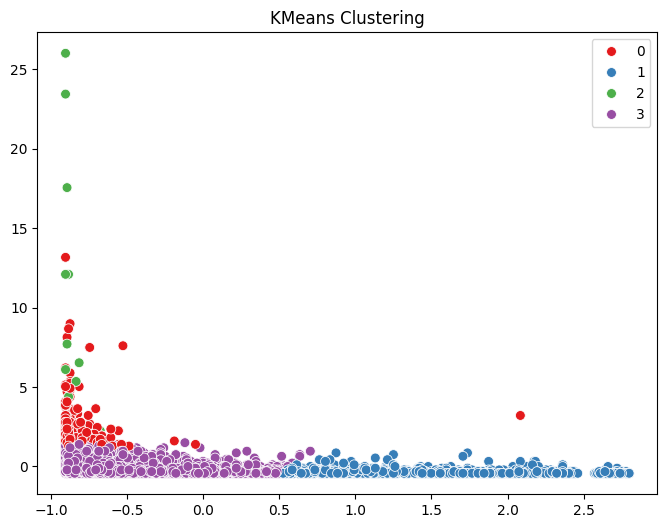

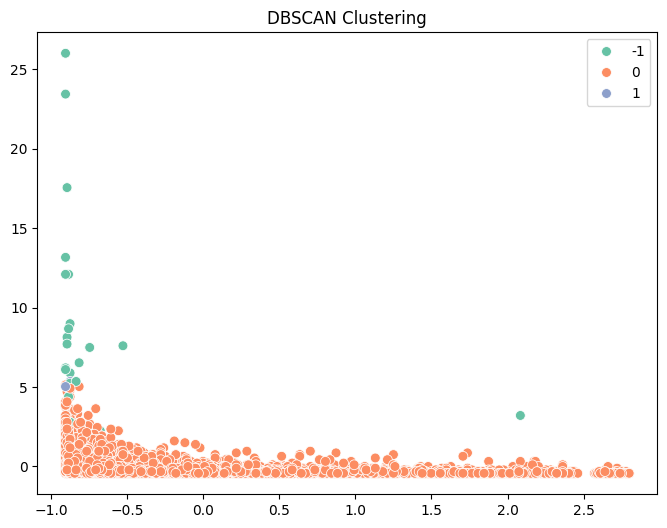

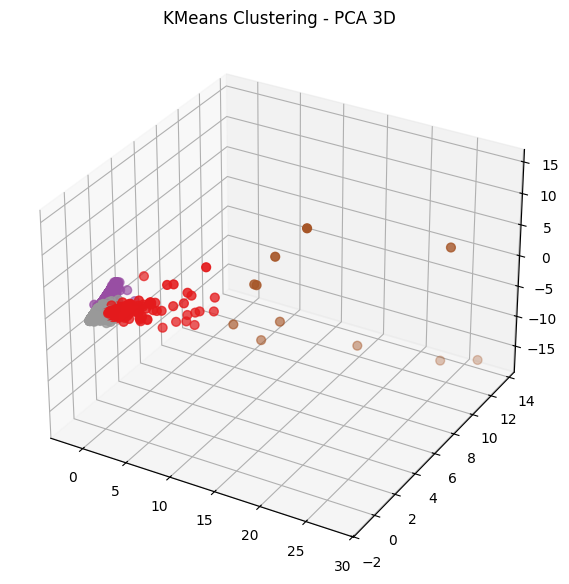

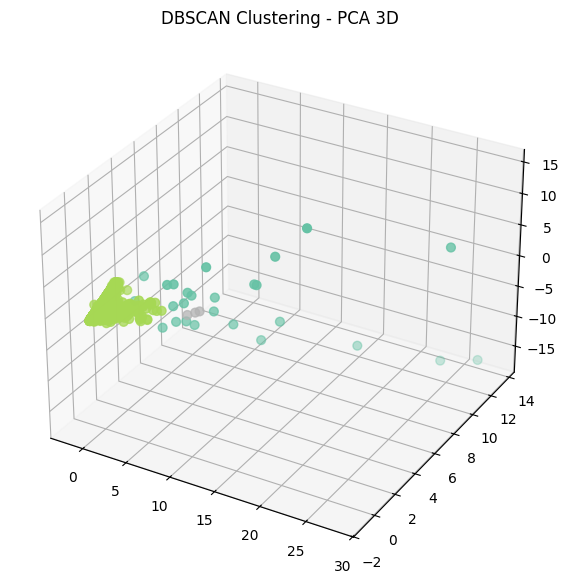

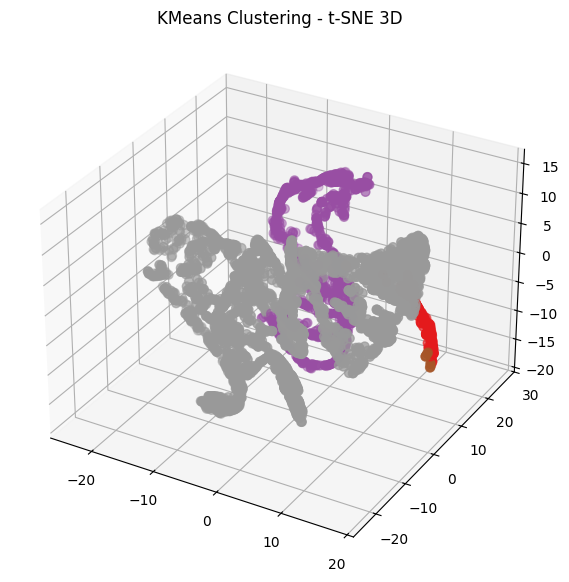

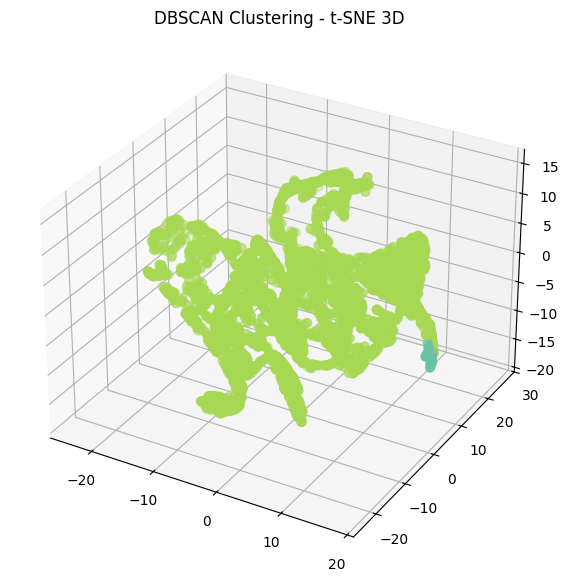

In [ ]:
# ======================
# 📌 IMPORT
# ======================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.spatial.distance import cdist

# ======================
# 📌 LOAD DATA
# ======================
url = 'https://raw.githubusercontent.com/farrelrassya/teachingMLDL/main/01.%20Machine%20Learning/06.%20Week%206/Datasets/Online%20Retail.xlsx'
df = pd.read_excel(url)

# ======================
# 📌 FEATURE ENGINEERING
# ======================
df.dropna(subset=['CustomerID'], inplace=True)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['TotalSum'] = df['Quantity'] * df['UnitPrice']

snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalSum': 'sum'
}).rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalSum': 'Monetary'
})

# ======================
# 📌 SCALING
# ======================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(rfm)

# ======================
# 📌 KMEANS + EVALUASI
# ======================
wcss = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(2,11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

best_k = 4
kmeans = KMeans(n_clusters=best_k, random_state=42)
k_labels = kmeans.fit_predict(X_scaled)

print("\nKMeans Silhouette Score:", silhouette_score(X_scaled, k_labels))
print("KMeans Calinski-Harabasz Index:", calinski_harabasz_score(X_scaled, k_labels))
print("KMeans Davies-Bouldin Index:", davies_bouldin_score(X_scaled, k_labels))

# ======================
# 📌 DBSCAN GRID SEARCH + EVALUASI
# ======================
eps_values = [0.5, 1.0, 1.5, 2.0]
min_samples_values = [3, 5, 7]
results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        db_labels = dbscan.fit_predict(X_scaled)
        mask = db_labels != -1
        unique_labels = np.unique(db_labels[mask])

        if len(unique_labels) > 1:
            sil = silhouette_score(X_scaled[mask], db_labels[mask])
            ch = calinski_harabasz_score(X_scaled[mask], db_labels[mask])
            dbi = davies_bouldin_score(X_scaled[mask], db_labels[mask])
        else:
            sil = ch = dbi = None

        results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': len(unique_labels),
            'silhouette': sil,
            'calinski_harabasz': ch,
            'davies_bouldin': dbi
        })

df_results = pd.DataFrame(results)
print("\nDBSCAN Grid Search Results:")
print(df_results)

# ======================
# 📌 PILIH DBSCAN TERBAIK
# ======================
valid_results = df_results.dropna().sort_values(by='silhouette', ascending=False)
if not valid_results.empty:
    best_result = valid_results.iloc[0]
    eps_best = best_result['eps']
    min_samples_best = int(best_result['min_samples'])

    dbscan_best = DBSCAN(eps=eps_best, min_samples=min_samples_best)
    db_labels_best = dbscan_best.fit_predict(X_scaled)

    print("\nBest DBSCAN Combination:")
    print(best_result)
else:
    print("\nDBSCAN tidak menghasilkan kombinasi valid (>=2 cluster).")

# ======================
# 📌 DUNN INDEX FUNCTION
# ======================
def dunn_index(X, labels):
    clusters = np.unique(labels)
    clusters = clusters[clusters != -1]
    if len(clusters) < 2:
        return None

    min_inter = np.inf
    max_intra = 0

    for i in clusters:
        Xi = X[labels == i]
        for j in clusters:
            if i >= j:
                continue
            Xj = X[labels == j]
            dist = cdist(Xi, Xj)
            min_inter = min(min_inter, np.min(dist))
        intra = cdist(Xi, Xi)
        max_intra = max(max_intra, np.max(intra))

    if max_intra == 0:
        return None
    return min_inter / max_intra

# Dunn KMeans
dunn_kmeans = dunn_index(X_scaled, k_labels)
print(f"\nKMeans Dunn Index: {dunn_kmeans:.4f}" if dunn_kmeans else "KMeans Dunn Index: Tidak valid")

# Dunn DBSCAN
if not valid_results.empty and len(np.unique(db_labels_best[db_labels_best != -1])) > 1:
    dunn_dbscan = dunn_index(X_scaled, db_labels_best)
    print(f"DBSCAN Dunn Index: {dunn_dbscan:.4f}" if dunn_dbscan else "DBSCAN Dunn Index: Tidak valid")
else:
    print("DBSCAN Dunn Index: Tidak valid (cluster < 2)")

# ======================
# 📌 VISUALISASI 2D
# ======================
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_scaled[:,0], y=X_scaled[:,1], hue=k_labels, palette='Set1', s=50)
plt.title("KMeans Clustering")
plt.show()

if not valid_results.empty:
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=X_scaled[:,0], y=X_scaled[:,1], hue=db_labels_best, palette='Set2', s=50)
    plt.title("DBSCAN Clustering")
    plt.show()

# ======================
# 📌 PCA 3D VISUALISASI
# ======================
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], c=k_labels, cmap='Set1', s=40)
ax.set_title("KMeans Clustering - PCA 3D")
plt.show()

if not valid_results.empty:
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], c=db_labels_best, cmap='Set2', s=40)
    ax.set_title("DBSCAN Clustering - PCA 3D")
    plt.show()

# ======================
# 📌 TSNE 3D VISUALISASI (opsional, agak berat)
# ======================
tsne = TSNE(n_components=3, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_tsne[:,0], X_tsne[:,1], X_tsne[:,2], c=k_labels, cmap='Set1', s=40)
ax.set_title("KMeans Clustering - t-SNE 3D")
plt.show()

if not valid_results.empty:
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_tsne[:,0], X_tsne[:,1], X_tsne[:,2], c=db_labels_best, cmap='Set2', s=40)
    ax.set_title("DBSCAN Clustering - t-SNE 3D")
    plt.show()


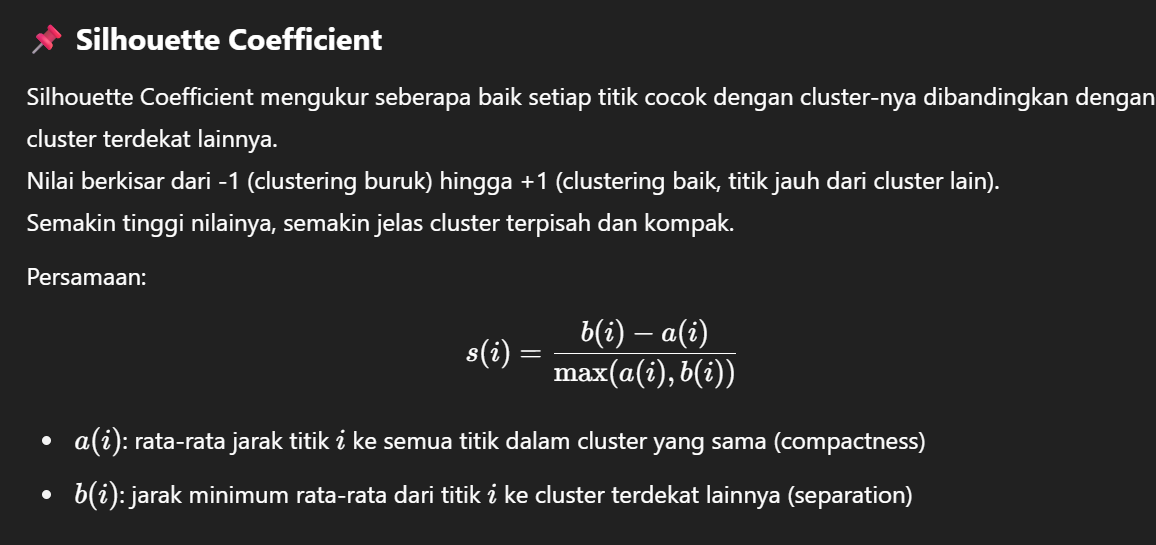

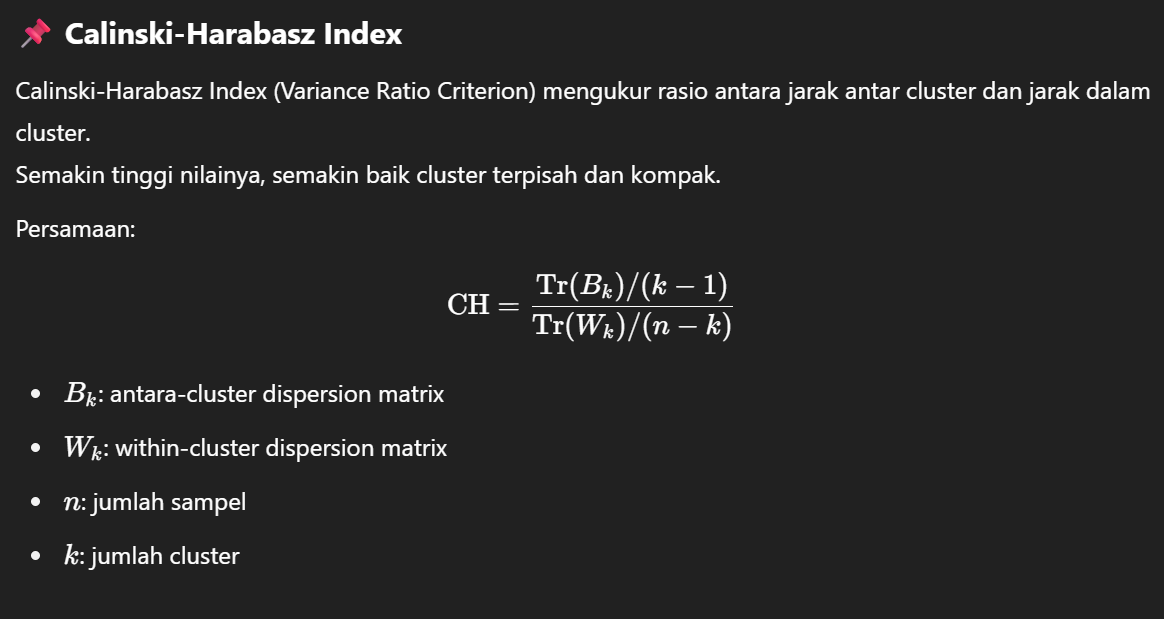

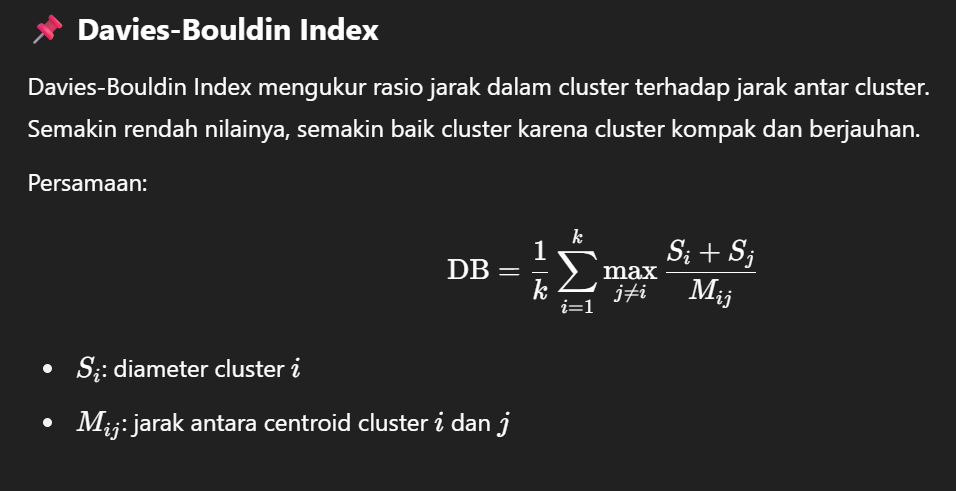

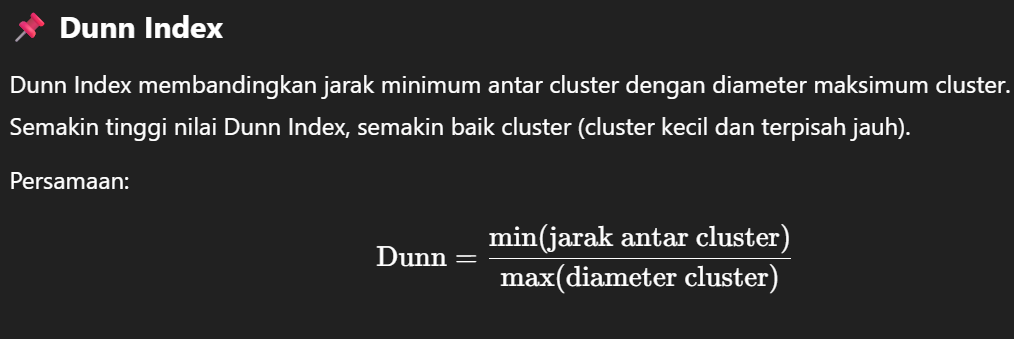

KMeans

Silhouette Score: Biasanya menghasilkan nilai tinggi (di atas 0.5) pada dataset terstruktur baik (cluster bulat/linier).

Calinski-Harabasz: Nilai CH sering sangat tinggi pada KMeans karena cluster kompak dan terpisah.

Davies-Bouldin: Nilai rendah (dekat 0) menunjukkan cluster baik pada KMeans.

Dunn Index: Sering tinggi karena KMeans cenderung hasilkan cluster dengan diameter kecil dan terpisah jelas.

\
DBSCAN
\
Silhouette Score: Sangat baik jika DBSCAN menemukan cluster alami (non-linier bentuk), tapi nilai dapat rendah jika noise banyak atau hanya 1 cluster valid.

Calinski-Harabasz: Bisa tinggi jika cluster yang dihasilkan DBSCAN kompak dan jelas terpisah, tapi rentan turun kalau noise banyak.

Davies-Bouldin: Nilai rendah mengindikasikan cluster yang baik, tapi jika banyak noise bisa misleading.

Dunn Index: Cocok untuk mengevaluasi DBSCAN karena dia sensitif pada jarak minimum antar cluster dan diameter.

\
Matrik mana terbaik?
\
Silhouette Score dan Dunn Index sering jadi matrik utama karena intuitif (semakin tinggi semakin baik, jelas cluster)

Calinski-Harabasz cocok untuk dataset linier/bulat (misal cocok untuk KMeans)

Davies-Bouldin cocok sebagai konfirmasi: semakin rendah semakin baik (cluster compact dan terpisah)